<a href="https://colab.research.google.com/github/pamelamurilloa/DataMining-ISW911-ThirdProject-MachineLearning/blob/main/red_neuronal_secuencial_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto III - Machine Learning

## 0. Descripción de las variables del dataset

1. **churn:** Indica si un cliente ha abandonado el servicio o no.
2. **accountlength:** Tiempo, en días, que el cliente lleva con el servicio.
3. **internationalplan:** Indica si el cliente tiene un plan de llamadas internacionales.
4. **voicemailplan:** Indica si el cliente tiene un plan de buzón de voz.
5. **numbervmailmessages:** Número de mensajes de voz recibidos por el cliente.
6. **totaldayminutes:** Total de minutos usados por el cliente durante el día.
7. **totaldaycalls:** Total de llamadas realizadas durante el día.
8. **totaldaycharge:** Costo total de las llamadas realizadas durante el día, en dólares.
9. **totaleveminutes:** Total de minutos usados por el cliente durante la tarde.
10. **totalevecalls:** Total de llamadas realizadas durante la tarde.
11. **totalevecharge:** Costo total de las llamadas realizadas durante la tarde, en dólares.
12. **totalnightminutes:** Total de minutos usados por el cliente durante la noche.
13. **totalnightcalls:** Total de llamadas realizadas durante la noche.
14. **totalnightcharge:** Costo total de las llamadas realizadas durante la noche, en dólares.
15. **totalintlminutes:** Total de minutos usados en llamadas internacionales.
16. **totalintlcalls:** Total de llamadas internacionales realizadas.
17. **totalintlcharge:** Costo total de las llamadas internacionales, en dólares.
18. **numbercustomerservicecalls:** Número de llamadas realizadas por el cliente al servicio de atención al cliente.

## 0.1. Cargar librerías previamente

In [172]:
# Carga de las librerias
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

## 1. Cargar el Conjunto de datos


### Cargar datos desde el repositorio a un dataframe

In [173]:
url ='https://raw.githubusercontent.com/pamelamurilloa/DataMining-ISW911-ThirdProject-MachineLearning/refs/heads/main/datos.csv'
df = pd.read_csv(url)

### Transformaciones previas

In [174]:
# Validar como vienen originalmente los tipos datos
print(df.dtypes)

churn                          object
accountlength                 float64
internationalplan              object
voicemailplan                  object
numbervmailmessages           float64
totaldayminutes               float64
totaldaycalls                 float64
totaldaycharge                float64
totaleveminutes               float64
totalevecalls                 float64
totalevecharge                float64
totalnightminutes             float64
totalnightcalls               float64
totalnightcharge              float64
totalintlminutes              float64
totalintlcalls                float64
totalintlcharge               float64
numbercustomerservicecalls    float64
dtype: object


In [175]:
# Convertir las variables categóricas a un formato category (equivalente a factor en R)
columns_to_convert = ['churn', 'internationalplan', 'voicemailplan']
df[columns_to_convert] = df[columns_to_convert].astype('category')

print(df.dtypes)

churn                         category
accountlength                  float64
internationalplan             category
voicemailplan                 category
numbervmailmessages            float64
totaldayminutes                float64
totaldaycalls                  float64
totaldaycharge                 float64
totaleveminutes                float64
totalevecalls                  float64
totalevecharge                 float64
totalnightminutes              float64
totalnightcalls                float64
totalnightcharge               float64
totalintlminutes               float64
totalintlcalls                 float64
totalintlcharge                float64
numbercustomerservicecalls     float64
dtype: object


## 2. División de los datos en conjuntos de entrenamiento y prueba

In [176]:
# Separar el conjunto de datos en un conjunto de entrenamiento y uno de prueba

# Esta separación esta enfocada en la predección de 'churn'

# Variables independientes:
x = df.loc[:, df.columns != 'churn']

# Variable dependiente:
y = df['churn']

# Dividir los datos en subconjuntos aleatorios de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
print('Conjunto de datos separado para entrenamiento y prueba.')

Conjunto de datos separado para entrenamiento y prueba.


## 3. Justificación de la selección del modelo de Machine Learning

Las redes neuronales es un modelado poderoso para la predicción del 'Churn' debido a su capacidad para modelar relaciones complejas, de esta forma se pueden identificar múltiples interacciones complejan que afecten la elección de los clientes lo que una red neuronal puede aprender y modelar eficazmente. A pesar de que puede ser un modelo, complejo este se puede mantener un poco más simple, debido a su flexibilidad en la configuración y adaptación a los datos, esto debido a que nos permiten ajustar las números de capas y neuronas. Por lo que, su capacidad de modelado de relaciones, manejo de grandes cantidades de datos y flexibilidad podrían asegurar un modelo robusto, también son consideradas una 'caja negra', más sin embargo existen herramientas como lo es SHAP o LIME.

## 4. Entrenamiento de Modelos de Machine Learning (Red Neuronal)


### Preprocesamiento adicional

In [177]:
# Codificación de variables categóricas en las variables categóricas de entrenamiento independientes

# One-Hot Encoding, manteniendo sólo una columna '..._yes'para evitar colinealidad
x_train = pd.get_dummies(x_train, drop_first=True)
x_test = pd.get_dummies(x_test, drop_first=True)

# Asegurar que ambas divisiones tengan las mismas columnas
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

In [178]:
# Codificación de churn (variable dependiente), convirtiendolas en valores binarios

le = LabelEncoder()
y_train = le.fit_transform(y_train) # Aprendiendo que No -> 0, Yes -> 1
y_test = le.transform(y_test) # Aquí ya lo aprendió, por ende sólo transforma

# Confirmación del mapeo
print(le.classes_)

['No' 'Yes']


### Definir estructura del modelo y compilarlo

In [179]:
# Crear modelo de red neuronal secuencial
model = Sequential()

In [180]:
# Definir capas

# - Agregar la capa de entrada explícita:
model.add(Input(shape=(x_train.shape[1],)))

# - Primer capa (entrada):
model.add(Dense(units=64, activation='relu'))

# - Capa oculta
model.add(Dense(units=32, activation='relu'))

# - Regular con Dropout
model.add(Dropout(0.5))

# - Capa de salida
model.add(Dense(units=1, activation='sigmoid'))

**Explicación:**

La capa de entrada recibe los datos y empieza aprenderse los patrones, mientras que la capa oculta introduce no linealidad y procesa interacciones más complejas, ya que este es su fin. Para estos dos puntos, se utilizan 64 y 32 neuronas debido a que es común y es preferido utilizar potencias de 2 como tendencia histórica.

Para la capa de salida se utiliza `sigmoid` este devuelve una probabilidad, en la que si es mayor a 0.5 retorna 1, de lo contrario 0, lo cual nos ayuda a ilustrar la clasificación binaria, donde se posee sólo una salida por la misma razón, en la que se quiere predecir entres 'Yes' y 'No'.

### Compilar el modelo

In [181]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Entrenar modelo

In [182]:
# Detiene el entrenamiento del modelo cuando no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Ajustar el modelo
history = model.fit(
    x_train, y_train,           # Datos de entrenamiento
    validation_split=0.2,       # Usar el 20% del entrenamiento como validación
    epochs=100,                 # Número máximo de épocas
    batch_size=32,               # Tamaño del lote
    callbacks=[early_stopping], # Para finalizar si después de 5 iteraciones no mejora
    verbose=2                   # Nivel de detalle de la salida
)

Epoch 1/100
88/88 - 2s - 28ms/step - accuracy: 0.8271 - loss: 0.4818 - val_accuracy: 0.8529 - val_loss: 0.4112
Epoch 2/100
88/88 - 0s - 4ms/step - accuracy: 0.8607 - loss: 0.3978 - val_accuracy: 0.8557 - val_loss: 0.4005
Epoch 3/100
88/88 - 0s - 5ms/step - accuracy: 0.8671 - loss: 0.3808 - val_accuracy: 0.8629 - val_loss: 0.3877
Epoch 4/100
88/88 - 0s - 2ms/step - accuracy: 0.8743 - loss: 0.3634 - val_accuracy: 0.8786 - val_loss: 0.3727
Epoch 5/100
88/88 - 0s - 3ms/step - accuracy: 0.8825 - loss: 0.3489 - val_accuracy: 0.8786 - val_loss: 0.3651
Epoch 6/100
88/88 - 0s - 3ms/step - accuracy: 0.8811 - loss: 0.3405 - val_accuracy: 0.8814 - val_loss: 0.3549
Epoch 7/100
88/88 - 0s - 4ms/step - accuracy: 0.8886 - loss: 0.3217 - val_accuracy: 0.8800 - val_loss: 0.3488
Epoch 8/100
88/88 - 0s - 3ms/step - accuracy: 0.8918 - loss: 0.3207 - val_accuracy: 0.8786 - val_loss: 0.3401
Epoch 9/100
88/88 - 0s - 4ms/step - accuracy: 0.8932 - loss: 0.3098 - val_accuracy: 0.8786 - val_loss: 0.3395
Epoch 10/

**Resultados del entrenamiento:**

- `accuracy`: Porcentaje de predicciones correctas entrenando.

- `loss`: Valor de la función de pérdida entrenando.

- `val_accuracy`: Porcentaje de predicciones correctas en el conjunto de validación.

- `val_loss`: Valor de la función de pérdida en el conjunto de validación.

### Visualizar resultados del rendimiento del entrenamiento

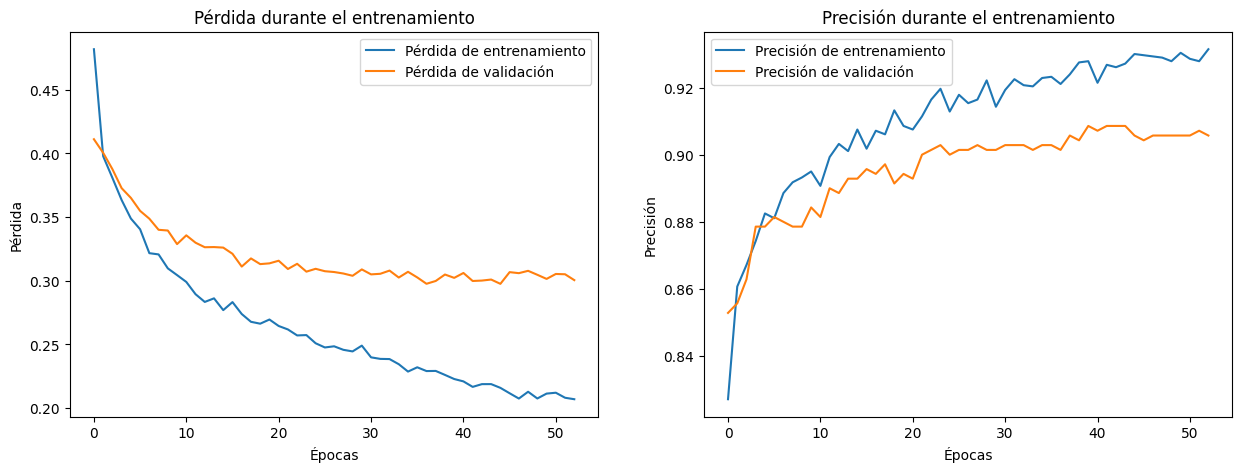

In [183]:
# Crear 2 columnas en 1 fila para los gráficos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pérdida
axes[0].plot(history.history['loss'], label='Pérdida de entrenamiento')
axes[0].plot(history.history['val_loss'], label='Pérdida de validación')
axes[0].legend()
axes[0].set_title('Pérdida durante el entrenamiento')
axes[0].set_xlabel('Épocas')
axes[0].set_ylabel('Pérdida')

# Precisión
axes[1].plot(history.history['accuracy'], label='Precisión de entrenamiento')
axes[1].plot(history.history['val_accuracy'], label='Precisión de validación')
axes[1].legend()
axes[1].set_title('Precisión durante el entrenamiento')
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Precisión')

plt.show()

## 5. Evaluación del modelo

### Evaluar modelo con los datos de prueba

In [184]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9176 - loss: 0.2673
Test Loss: 0.2704249322414398, Test Accuracy: 0.9106666445732117


Comparar resultados:

`loss` < `val_loss` ≈ `test_loss` → El modelo generaliza bien.

`loss` < `val_loss` < `test_loss` → Indica un posible sobreajuste.

### Matriz de confusión y métricas adicionales

In [185]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[1278   20]
 [ 114   88]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1298
           1       0.81      0.44      0.57       202

    accuracy                           0.91      1500
   macro avg       0.87      0.71      0.76      1500
weighted avg       0.90      0.91      0.90      1500



### Calculo de Métricas

In [187]:
# Generar las predicciones del modelo (en probabilidades)
y_pred_prob = model.predict(x_test)

# Convertir las probabilidades a 0/1:
y_pred_class = (y_pred_prob > 0.5).astype("int32")

# Calcular el Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_prob)
print("Mean Squared Error (MSE):", mse)

# Calcular el Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_prob)
print("Mean Absolute Error (MAE):", mae)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 0.07207955006589649
Mean Absolute Error (MAE): 0.14037466819778396


### Curva ROC y AUC

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


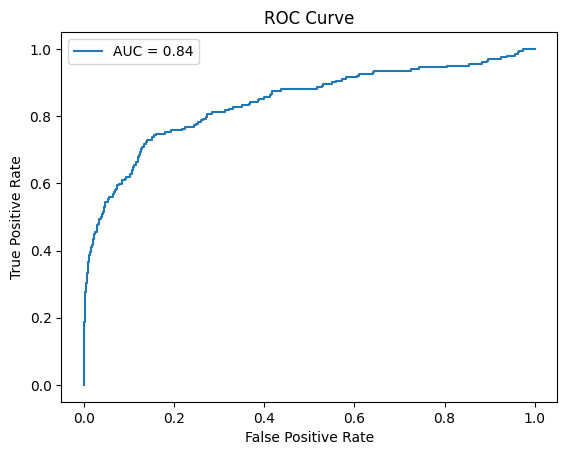

In [146]:
y_pred_prob = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## 6. Ajustes de Parámetros